In [1]:
###########################################
# This file contains the following:
# 1. Linear Transformer Model (modified for simpler gating)
# 2. Function for clipping gradient
# 3. Function for generating random data
###########################################

import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def attention(P,Q,Z, activation = None):
    B= Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    P_full =  torch.cat([P,torch.zeros(1,d).to(device)],dim=0)
    P_full =  torch.cat([P_full,torch.zeros(d+1,1).to(device)],dim=1)
    P_full[d,d] = 1
    Q_full = torch.cat([Q, torch.zeros(1,d).to(device)],dim=0)
    Q_full = torch.cat([Q_full, torch.zeros(d+1,1).to(device)],dim=1)
    A = torch.eye(N+1).to(device)
    A[N,N] = 0
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z,Q_full,Z))
    if activation is not None:
        Attn = activation(Attn)
    key = torch.einsum('ij, BNj -> BNi', (P_full,Z))
    Output = torch.einsum('BNM,ML, BLi -> BNi', (Attn,A,key))
    return Output /N

class Transformer_F(nn.Module):
    def __init__(self, n_layer, n_head, N, d, var, run_mode, head_choice=None):
        super(Transformer_F, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))

        # self.gamma = nn.Parameter(torch.zeros(n_layer, 1, N+1, d+1), requires_grad=(run_mode == 1))

        with torch.no_grad():
            self.allparam.normal_(0, var)

        self.n_layer = n_layer
        self.n_head = n_head
        self.run_mode = run_mode
        self.head_choice = head_choice  # The chosen head index for run_mode=0

        # Simplified gating mechanism:
        # One gating parameter per head for all layers.
        self.gate = nn.Parameter(torch.zeros(n_head), requires_grad=(run_mode == 1))

    def forward(self, Z):
        B, N, d = Z.shape[0], Z.shape[1]-1, Z.shape[2]-1

        # R = [torch.zeros_like(Z) for _ in range(self.n_layer)]

        # self.zero_p()

        # If run_mode=1, precompute the gating weights once
        if self.run_mode == 1:
        # Directly use gate parameters
        # This might mean some heads get negative weights unless you ensure non-negativity
          #gate_weights = F.softmax(self.gate, dim=-1)  # (n_head,)
          gate_weights_expanded = self.gate.view(-1, 1, 1, 1)

        for i in range(self.n_layer):
            Zi = Z

            if self.run_mode == 0:
                # If no head_choice is provided, default to head 0
                chosen_head = self.head_choice if self.head_choice is not None else 0
                Pij = self.allparam[i, chosen_head, 0, :, :]
                Qij = self.allparam[i, chosen_head, 1, :, :]
                attention_sum = attention(Pij, Qij, Zi)

            elif self.run_mode == 1:
                # Compute attention for all heads
                head_attentions = []
                for j in range(self.n_head):
                    Pij = self.allparam[i, j, 0, :, :]
                    Qij = self.allparam[i, j, 1, :, :]
                    head_attentions.append(attention(Pij, Qij, Zi))
                head_attentions = torch.stack(head_attentions, dim=0)  # (n_head, B, N+1, d+1)

                # Apply gating: use same weights for all layers
                attention_sum = (head_attentions * gate_weights_expanded).sum(dim=0)

            else:
                raise ValueError("Invalid run_mode. Should be 0 or 1.")

            # Compute the residual and update Z
            # R[i] = attention_sum
            Z = Zi + attention_sum
        return Z

    def zero_p(self):
      for i in range(self.n_layer):
          for j in range(self.n_head):
              with torch.no_grad():
                  self.allparam[i,j,0,:,:].zero_()

def in_context_loss(model, Z, y):
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    output = model(Z)
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean()
    return loss

def generate_data(mode='normal',N=20,d=1,B=1000,shape_k=0.1, U=None, D=None, data_variance=1.0):
    std = math.sqrt(data_variance)
    W= torch.FloatTensor(B, d).normal_(0, std).to(device)
    X = torch.FloatTensor(B, N, d).normal_(0, std).to(device)
    X_test = torch.FloatTensor(B,1,d).normal_(0, std).to(device)

    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W= torch.FloatTensor(B, d).normal_(0, std).to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())

    if mode =='sphere':
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
    elif mode == 'gamma':
        gamma_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,N])
        gamma_scales = torch.Tensor(gamma_scales).to(device)
        gamma_scales = gamma_scales.sqrt()
        gamma_test_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,1])
        gamma_test_scales = torch.Tensor(gamma_test_scales).to(device)
        gamma_test_scales = gamma_test_scales.sqrt()
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
        X.mul_(gamma_scales[:,:,None])
        X_test.mul_(gamma_test_scales[:,:,None])
    elif mode == 'normal':
        pass
    elif mode == 'relu':
        return generate_data_relu(N=N, d=d, B=B, hidden_dim=d)
    elif mode == 'mlp':
        return generate_data_mlp(N=N, d=d, B=B, hidden_dim=d)
    else:
        assert False

    if U is not None:
        X = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))
        X_test = torch.einsum('ij, jk, BNk -> BNi', (U,D,X_test))

    y = torch.einsum('bi,bni->bn', (W, X)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test)).squeeze(1)
    X_comb= torch.cat([X,X_test],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)
    return Z.to(device),y_test.to(device)

def generate_data_inplace(Z, U=None, D=None):
    B = Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    X = Z[:,:,0:-1]
    X.normal_(0, 1).to(device)
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())
        Z[:,:,0:-1] = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))

    Z[:,:,-1] = torch.einsum('bi,bni->bn', (W, Z[:,:,0:-1]))
    y_test = Z[:,-1,-1].detach().clone()
    Z[:,-1,-1].zero_()
    return Z.to(device),y_test.to(device)

def generate_data_sine(N=10, B=1000):
    a = torch.FloatTensor(B).uniform_(0.1, 5).to(device)
    p = torch.FloatTensor(B).uniform_(0, math.pi).to(device)

    X = torch.FloatTensor(B, N).uniform_(-5, 5).to(device)
    Y = a.unsqueeze(1) * torch.sin(p.unsqueeze(1) + X)

    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)

    return X, Y

def generate_data_relu(mode='normal', N=20, d=1, B=1000, shape_k=0.1, U=None, D=None, hidden_dim=100):
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    ).to(device)
    model[0].weight.data.normal_(0, 0.1)
    model[2].weight.data.normal_(0, 0.1)

    y = model(X.view(-1, d)).view(B, N, 1)
    y_test = model(X_test.view(-1, d)).view(B, 1).squeeze(1)

    y_zero = torch.zeros(B, 1, 1).to(device)
    X_comb = torch.cat([X, X_test], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)

    return Z, y_test

def generate_data_mlp(N=20, d=1, B=1000, hidden_dim=100):
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, d)
    ).to(device)
    model[0].weight.data.normal_(0, 1)
    model[2].weight.data.normal_(0, 1)

    X_MLP = model(X.view(-1, d)).view(B, N, d)
    X_test_MLP = model(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0,1).to(device)
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)
    X_comb= torch.cat([X_MLP,X_test_MLP],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)

    return Z, y_test

In [1]:
!cp /content/linear_transformer.py /content/

cp: '/content/linear_transformer.py' and '/content/linear_transformer.py' are the same file


In [2]:
import linear_transformer

In [3]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

##############################################################################################################
# Trains a linear Transformer with 1,2,3,4 layers
# Plots the test loss of trained Transformer against 1,2,3,4 steps of gradient descent (with and without preconditioning)
##############################################################################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log'
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [4]:
# Set up problem parameters

lr = 0.01
clip_r = 0.01
alg = 'adam'
mode = 'normal'

n_layer = 4  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 3  # 1-headed attention
B = 1000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 10  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        for l in range(grad_all.shape[0]):
            for h in range(grad_all.shape[1]):
                for t in range(grad_all.shape[2]):
                    norm_p = grad_all[l,h,t,:,:].norm().item()
                    if norm_p > clip_r:
                        grad_all[l,h,t,:,:].mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

#format for saving run data
filename_format = '/variable_L_hist_{}_{}_{}.pth'
n_layers = [1,2,3,4]  # number of layers of transformer
seeds=[0,1,2,3,4]
keys = []
for s in seeds:
    for n_layer in n_layers:
        keys.append((s,n_layer,))

In [24]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict001 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [0.5, 1.0, 2.0]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict001[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 0.01)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict001[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [25]:
loss_dict001

{(0,): tensor([-7.87, -7.94, -7.93, -8.04])}

In [27]:
model.gate

Parameter containing:
tensor([4.36, 4.30, 4.29], device='cuda:0', requires_grad=True)

In [9]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict01 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [0.5, 1.0, 2.0]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict01[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 0.1)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict01[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [10]:
loss_dict01

{(0,): tensor([-3.83, -3.87, -4.01, -4.18])}

In [11]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict05 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [0.5, 1.0, 2.0]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict05[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 0.5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict05[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [12]:
loss_dict05

{(0,): tensor([-1.03, -1.63, -2.32, -2.62])}

In [13]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict1 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [0.5, 1.0, 2.0]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict1[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict1[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [14]:
loss_dict1

{(0,): tensor([ 0.25, -0.52, -1.69, -2.39])}

In [15]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict2 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [0.5, 1.0, 2.0]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict2[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 2)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict2[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [16]:
loss_dict2

{(0,): tensor([ 1.64,  0.87, -0.32, -1.09])}

In [17]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict3 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [0.5, 1.0, 2.0]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict3[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 3)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict3[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [18]:
loss_dict3

{(0,): tensor([ 2.45,  1.68,  0.49, -0.27])}

In [21]:
########################################################
# Modified Training/Testing Code for the Transformer Model
# - Removed validation fine-tuning step
# - Incorporate all layers parameters for each head
########################################################

loss_dict5 = {}
store = 0
Z_val = 0
y_val = 0

# Suppose we have 3 heads:
n_head = 3
variances = [0.5, 1.0, 2.0]  # Each head is trained on a different Gaussian variance
seeds=[0]

for sd in seeds:
    key = (sd,)
    loss_dict5[key] = torch.zeros(len(n_layers))
    for idx, n_layer in enumerate(n_layers):
        # ----------------------------------------------
        # Step 1: Train each head separately (run_mode=0)
        # ----------------------------------------------
        head_params_list = []
        for head_idx in range(n_head):
            # Create a fresh model for this head
            head_model = Transformer_F(n_layer, n_head, N, d, var, run_mode=0, head_choice=head_idx).to(device)
            head_model.train()

            # Generate training data for this head
            data_variance = variances[head_idx]
            gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
            U = torch.linalg.svd(gaus)[0].to(device)
            D = torch.diag(torch.FloatTensor([1, 1, 1/2, 1/4, 1])).to(device)
            Z_train, y_train = generate_data(mode, N, d, B, shape_k, U, D, data_variance=data_variance)
            Z_train, y_train = Z_train.to(device), y_train.to(device)

            # Train only this head’s parameters
            optimizer_head = torch.optim.Adam([head_model.allparam], lr=lr)
            epochs = 500
            for epoch in range(epochs):
                optimizer_head.zero_grad()
                loss = in_context_loss(head_model, Z_train, y_train)
                loss.backward()
                optimizer_head.step()

            # Store this head’s trained parameters
            trained_state = head_model.state_dict()
            head_params_list.append(trained_state['allparam'].clone().detach())

        # ----------------------------------------------
        # Step 2: Combine heads into a single model (run_mode=1)
        # ----------------------------------------------
        model = Transformer_F(n_layer, n_head, N, d, var, run_mode=1).to(device)
        combined_state = model.state_dict()

        # Incorporate all layers' parameters for each head
        # head_params_list[head_idx] has shape (n_layer, n_head, 2, d, d)
        # We must copy for each layer and each head
        for i_layer in range(n_layer):
            for head_idx in range(n_head):
                combined_state['allparam'][i_layer, head_idx, :, :, :] = head_params_list[head_idx][i_layer, head_idx, :, :, :]

        model.load_state_dict(combined_state)
        model.eval()

        # ----------------------------------------------
        # Step 3: Fine-tune gating parameters on test data
        # (No validation fine-tuning of allparam; we skip that step now)
        # ----------------------------------------------

        # Generate new test data and fine-tune gamma/gate
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 5)
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.gate.requires_grad = True
        # Freeze allparam if you do not want to alter head parameters
        model.allparam.requires_grad = False

        optimizer2 = torch.optim.Adam([model.gate], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # ----------------------------------------------
        # Step 4: Compute test loss and store
        # ----------------------------------------------
        with torch.no_grad():
            final_loss = in_context_loss(model, Z_test, y_test)
            loss_dict5[key][idx] = final_loss.log().item()

# After this loop completes, loss_dict will contain the logged test losses for each seed and layer configuration.

In [23]:
loss_dict5

{(0,): tensor([3.47, 2.70, 1.51, 0.75])}

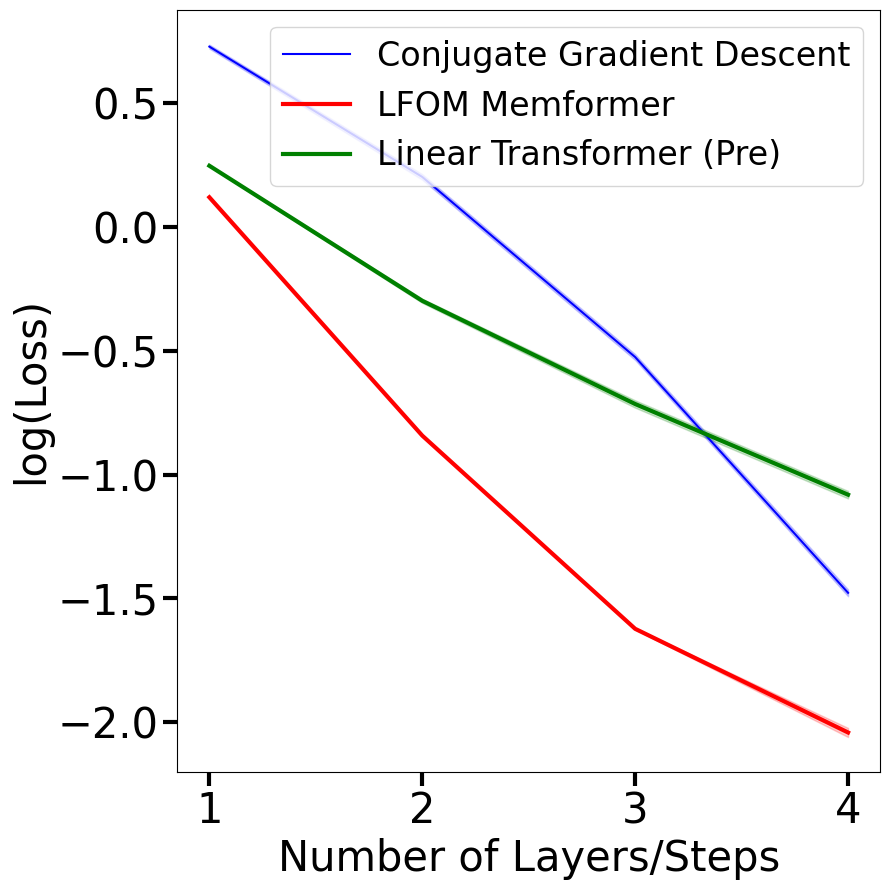

In [ ]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (9, 9))

losses = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict.keys()
for idx, key in enumerate(keys):
    losses[idx,:] = loss_dict[key]
losses_mean = torch.mean(losses, axis=0)
losses_std = torch.std(losses, axis=0)/10

losses_zero = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict_zero.keys()
for idx, key in enumerate(keys):
    losses_zero[idx,:] = loss_dict_zero[key]
losses_mean_zero = torch.mean(losses_zero, axis=0)
losses_std_zero = torch.std(losses_zero, axis=0)/10

plt.plot(n_layers, gd_loss_mean, color='blue', label='Conjugate Gradient Descent')
plt.fill_between(n_layers, gd_loss_mean - gd_loss_std/10, gd_loss_mean + gd_loss_std/10, color='blue', alpha=0.2)

ax.plot(n_layers, losses_mean, color = 'red', lw = 3, label='LFOM Memformer')
ax.fill_between(n_layers, losses_mean-losses_std, losses_mean+losses_std, color = 'red', alpha = 0.2)

ax.plot(n_layers, losses_mean_zero, color = 'green', lw = 3, label='Linear Transformer (Pre)')
ax.fill_between(n_layers, losses_mean_zero-losses_std_zero, losses_mean_zero+losses_std_zero, color = 'green', alpha = 0.2)

plt.ylabel('log(Loss)',fontsize=30)
plt.xlabel('Number of Layers/Steps',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
ax.legend(fontsize=24)
#ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)

In [ ]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict1 = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict1[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, N, d, var, 1).to(device)

        # Fine-tune beta on the validation data
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        # Generate new test data after fine-tuning beta
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1)
        #Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.alpha.requires_grad = True
        model.gamma.requires_grad = True

        optimizer2 = torch.optim.Adam([model.alpha, model.gamma], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # Compute loss after fine-tuning and on the new test data
        with torch.no_grad():
            loss_dict1[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

<ipython-input-63-dece0b402e5d>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-63-dece0b402e5d>:15: FutureWarning: You 

In [ ]:
loss_dict1

{(0,): tensor([ 0.54,  0.02, -0.45, -0.86]),
 (1,): tensor([ 0.53, -0.17, -0.65, -1.08]),
 (2,): tensor([ 0.52, -0.08, -0.50, -0.99]),
 (3,): tensor([ 0.47, -0.19, -0.65, -1.04]),
 (4,): tensor([ 0.51, -0.06, -0.50, -0.85])}

In [ ]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict2 = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict2[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, N, d, var, 1).to(device)

        # Fine-tune beta on the validation data
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        # Generate new test data after fine-tuning beta
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1.1)
        #Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.alpha.requires_grad = True
        model.gamma.requires_grad = True

        optimizer2 = torch.optim.Adam([model.alpha, model.gamma], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # Compute loss after fine-tuning and on the new test data
        with torch.no_grad():
            loss_dict2[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

<ipython-input-92-f21af49b5265>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-92-f21af49b5265>:15: FutureWarning: You 

In [ ]:
loss_dict2

{(0,): tensor([ 0.72,  0.32, -0.13, -0.56]),
 (1,): tensor([ 0.70,  0.03, -0.48, -0.84]),
 (2,): tensor([ 0.70,  0.18, -0.25, -0.69]),
 (3,): tensor([ 0.64,  0.03, -0.44, -0.76]),
 (4,): tensor([ 0.69,  0.22, -0.14, -0.48])}

In [ ]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict3 = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict3[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, N, d, var, 1).to(device)

        # Fine-tune beta on the validation data
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        # Generate new test data after fine-tuning beta
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1.2)
        #Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.alpha.requires_grad = True
        model.gamma.requires_grad = True

        optimizer2 = torch.optim.Adam([model.alpha, model.gamma], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # Compute loss after fine-tuning and on the new test data
        with torch.no_grad():
            loss_dict3[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

<ipython-input-69-6403526d0694>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-69-6403526d0694>:15: FutureWarning: You 

In [ ]:
loss_dict3

{(0,): tensor([ 0.91,  0.71,  0.37, -0.03]),
 (1,): tensor([ 0.89,  0.32, -0.19, -0.36]),
 (2,): tensor([ 0.89,  0.55,  0.17, -0.13]),
 (3,): tensor([ 0.83,  0.35, -0.08, -0.24]),
 (4,): tensor([0.88, 0.59, 0.40, 0.09])}

In [ ]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict4 = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict4[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, N, d, var, 1).to(device)

        # Fine-tune beta on the validation data
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        # Generate new test data after fine-tuning beta
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1.3)
        #Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.alpha.requires_grad = True
        model.gamma.requires_grad = True

        optimizer2 = torch.optim.Adam([model.alpha, model.gamma], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # Compute loss after fine-tuning and on the new test data
        with torch.no_grad():
            loss_dict4[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

<ipython-input-71-8da54a8d0ef7>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-71-8da54a8d0ef7>:15: FutureWarning: You 

In [ ]:
loss_dict4

{(0,): tensor([1.13, 1.17, 0.99, 0.68]),
 (1,): tensor([1.10, 0.71, 0.26, 0.33]),
 (2,): tensor([1.10, 0.99, 0.73, 0.58]),
 (3,): tensor([1.04, 0.76, 0.41, 0.45]),
 (4,): tensor([1.10, 1.04, 1.03, 0.80])}

In [ ]:
########################################################
# compute test loss for trained linear Transformers
########################################################
loss_dict5 = {}
store = 0
Z_val = 0
y_val = 0
for sd in seeds:
    key = (sd,)
    loss_dict5[key] = torch.zeros(4)
    for n_layer in n_layers:
        # Load parameters for given n_layer and seed
        filename = cur_dir + filename_format.format(n_layer, N, sd)
        hist = torch.load(filename)['hist']
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Validation set to find the best model and fine-tune beta_param
        np.random.seed(999)
        torch.manual_seed(999)
        Z_val, y_val = generate_data(mode, N, d, B, shape_k, U, D, 1)
        Z_val = Z_val.to(device)
        y_val = y_val.to(device)
        model = Transformer_F(n_layer, n_head, N, d, var, 1).to(device)

        # Fine-tune beta on the validation data
        model.allparam.requires_grad = True

        model.allparam.data.copy_(hist[-1])

        # Use Adam optimizer for fine-tuning
        optimizer = torch.optim.Adam([model.allparam], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer.zero_grad()
            loss = in_context_loss(model, Z_val, y_val)
            loss.backward()
            optimizer.step()

        # Generate new test data after fine-tuning beta
        np.random.seed(99)
        torch.manual_seed(99)
        Z_test, y_test = generate_data(mode, N, d, B, shape_k, U, D, 1.4)
        #Z_test, y_test = Z_val, y_val
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        model.alpha.requires_grad = True
        model.gamma.requires_grad = True

        optimizer2 = torch.optim.Adam([model.alpha, model.gamma], lr=lr)

        fine_tune_iters = 500
        for t in range(fine_tune_iters):  # fine_tune_iters: number of fine-tuning steps
            optimizer2.zero_grad()
            loss = in_context_loss(model, Z_test, y_test)
            loss.backward()
            optimizer2.step()

        # Compute loss after fine-tuning and on the new test data
        with torch.no_grad():
            loss_dict5[key][n_layer - 1] = in_context_loss(model, Z_test, y_test).log().item()

<ipython-input-73-22f2da8ee461>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hist = torch.load(filename)['hist']
<ipython-input-73-22f2da8ee461>:15: FutureWarning: You 

In [ ]:
loss_dict5

{(0,): tensor([1.36, 1.66, 1.64, 1.45]),
 (1,): tensor([1.33, 1.15, 0.82, 1.11]),
 (2,): tensor([1.33, 1.48, 1.35, 1.33]),
 (3,): tensor([1.27, 1.22, 0.99, 1.19]),
 (4,): tensor([1.33, 1.51, 1.68, 1.55])}

{(0,): tensor([0.91, 0.00, 0.00, 0.00])}

<ipython-input-30-1c4c38a3e38a>:15: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std001 = torch.std(losses001, axis=0)/10
<ipython-input-30-1c4c38a3e38a>:25: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std01 = torch.std(losses01, axis=0)/10
<ipython-input-30-1c4c38a3e38a>:35: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  losses_std2 = torch.std(losses2, axis=0)/10
<ipython-input-30-1c4c38a3e38a>:45: UserWarning: std(): degrees of freedom is <= 0. Correction

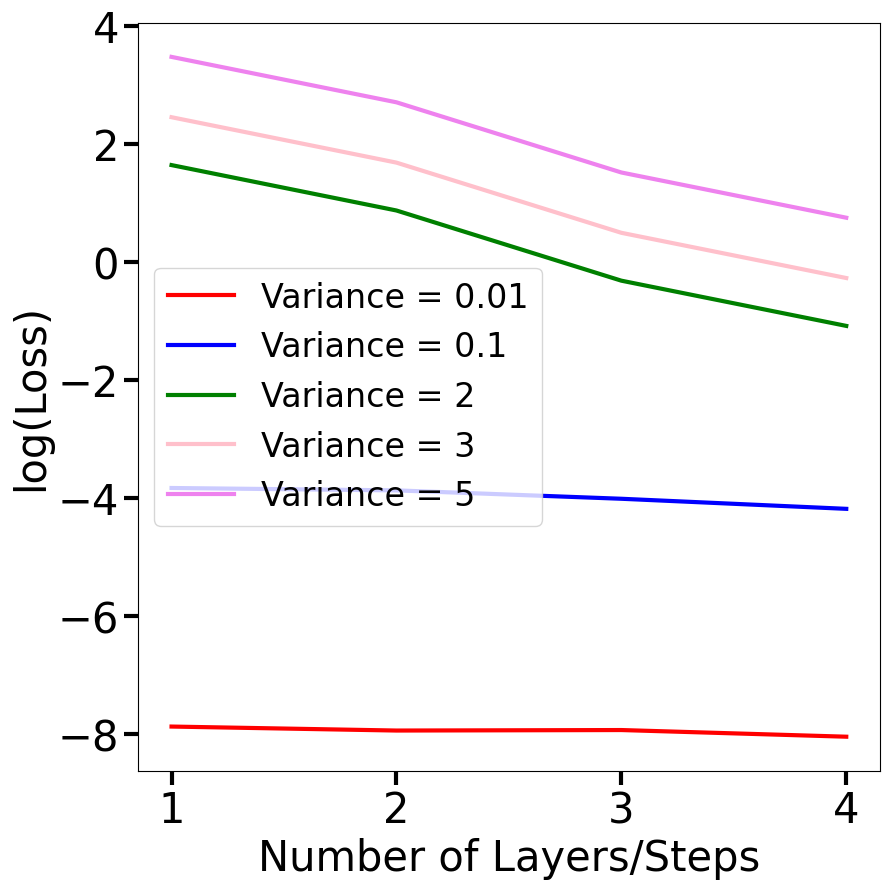

In [30]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (9, 9))

losses001 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict001.keys()
for idx, key in enumerate(keys):
    losses001[idx,:] = loss_dict001[key]
losses_mean001 = torch.mean(losses001, axis=0)
losses_std001 = torch.std(losses001, axis=0)/10

ax.plot(n_layers, losses_mean001, color = 'red', lw = 3, label='Variance = 0.01')
#ax.fill_between(n_layers, losses_mean1-losses_std1, losses_mean1+losses_std1, color = 'red', alpha = 0.2)

losses01 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict01.keys()
for idx, key in enumerate(keys):
    losses01[idx,:] = loss_dict01[key]
losses_mean01 = torch.mean(losses01, axis=0)
losses_std01 = torch.std(losses01, axis=0)/10

ax.plot(n_layers, losses_mean01, color = 'blue', lw = 3, label='Variance = 0.1')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses2 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict2.keys()
for idx, key in enumerate(keys):
    losses2[idx,:] = loss_dict2[key]
losses_mean2 = torch.mean(losses2, axis=0)
losses_std2 = torch.std(losses2, axis=0)/10

ax.plot(n_layers, losses_mean2, color = 'green', lw = 3, label='Variance = 2')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses3 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict3.keys()
for idx, key in enumerate(keys):
    losses3[idx,:] = loss_dict3[key]
losses_mean3 = torch.mean(losses3, axis=0)
losses_std3 = torch.std(losses3, axis=0)/10

ax.plot(n_layers, losses_mean3, color = 'pink', lw = 3, label='Variance = 3')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

losses5 = torch.zeros(len(seeds), len(n_layers))
keys = loss_dict5.keys()
for idx, key in enumerate(keys):
    losses5[idx,:] = loss_dict5[key]
losses_mean5 = torch.mean(losses5, axis=0)
losses_std5 = torch.std(losses5, axis=0)/10

ax.plot(n_layers, losses_mean5, color = 'violet', lw = 3, label='Variance = 5')
#ax.fill_between(n_layers, losses_mean2-losses_std2, losses_mean1+losses_std2, color = 'red', alpha = 0.2)

plt.ylabel('log(Loss)',fontsize=30)
plt.xlabel('Number of Layers/Steps',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
ax.legend(fontsize=24)
#ax.set_yscale('log')

plt.tight_layout()
plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)